# Don't make Cognitive Mistakes with Data!
## Setup
* Open a new Spark Notebook in Fabric
* Open vscode and ensure you are logged in and have the Fabric Data Engineering extension installed
* Go back to your Spark Notebook adn choose Open in vscode.

Let's Begin

First load our sample data. Can ghcp help us?

>Prompt:

Can you load a file to my lakehouse and then load it into a SQL Table called DrillPressData. The file is a csv, it has headers, and it is available on a public gh repo: https://raw.githubusercontent.com/davew-msft/vibe-analytics/refs/heads/main/drill_data.csv

In [1]:
# Load CSV from GitHub and save to lakehouse
import pandas as pd
import requests
from io import StringIO

# Download the CSV file from GitHub
url = "https://raw.githubusercontent.com/davew-msft/vibe-analytics/refs/heads/main/drill_data.csv"
response = requests.get(url)
csv_data = StringIO(response.text)

# Read CSV into pandas DataFrame
df = pd.read_csv(csv_data)

# Display first few rows to verify
print(f"Loaded {len(df)} rows")
df.head()

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 8, Finished, Available, Finished)

Loaded 400 rows


,HoleID,DrillID,OperatorName,HoleDiameter
0,1,1,Andy,3.09
1,2,1,Andy,3.08
2,3,1,Andy,3.15
3,4,1,Andy,3.12
4,5,1,Andy,3.05


In [ ]:
# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Write to lakehouse as Delta table
table_name = "DrillPressData"
spark_df.write.mode("overwrite").format("delta").saveAsTable(table_name)

print(f"Successfully created table: {table_name}")
print(f"Row count: {spark_df.count()}")

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 20, Finished, Available, Finished)

Successfully created table: DrillPressData
Row count: 400


In [3]:
# Verify the table was created and query it
spark.sql(f"SELECT * FROM {table_name} LIMIT 10").show()

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 22, Finished, Available, Finished)

+------+-------+------------+------------+
|HoleID|DrillID|OperatorName|HoleDiameter|
+------+-------+------------+------------+
|   291|      3|       Steve|        2.59|
|   292|      3|       Steve|        2.61|
|   301|      4|        Nick|        2.99|
|   302|      4|        Nick|        2.85|
|   303|      4|        Nick|        3.12|
|   304|      4|        Nick|        2.78|
|   305|      4|        Nick|        3.45|
|   306|      4|        Nick|        2.65|
|   307|      4|        Nick|        3.21|
|   308|      4|        Nick|        2.93|
+------+-------+------------+------------+



## Now Let's Describe the Business Problem to the LLM and see if it can help us
>Prompt:  

Context: Our company manufactures BIG pieces of steel used to make bridge abutments. Part of what we do is drill big 3 inch holes into big pieces of steel so we can connect the abutments together. It is extremely expensive to drill holes in thick steel that are EXACTLY 3 inches. If the hole isn't EXACTLY 3 inches then we have to scrap the steel and that causes cost overruns.

We've had a lot of cost overruns lately so we decided to buy a new drill press to drill these holes. There are 4 vendors that make these drill presses and we've had each of them come out to our manufacturing site and setup their drill presses so we can try them out. It takes a few days for each of the vendors' engineers to setup the press and "zero it in" so it is ready for our testing.

The drills have similar published specs and similar prices. We simply need to know WHICH drill press drills the best 3 inch holes.

After each vendor told us their drill press was ready for testing we tested on Monday morning. Here's how we designed our experiment:

* Each machine was allowed to start and warm up for an hour
* We picked 4 of our "drill press operators" off the floor to help us, at random. 
* They were allowed one hour to learn the new drill they were assigned to.
  * DrillID: 1 was operated by Andy
  * DrillID: 2 was operated by Bill
  * DrillID: 3 was operated by Steve
  * DrillID: 4 was operated by Nick
* The 4 operators were given 2 hours to drill 100 holes, labeled in the data as HoleID.  
* Each hole was to be representative of the expectation for the drill presses in production
* 3 inch diameter hole through 6inch thick steel

We've looked at the results which as in `DrillPressData` table.  

Role: You are a data scientist well-versed in the manufacturing industry helping companies improve their manufacturing decisions. We've brought you in to help us make our capital purchasing decision - or - show us what we should be thinking about or doing wrong.

Interview: I am the Manufacturing VP. I want YOU to help me figure out the data from the experiment we conducted. Ask me any questions that may help you dive deeper and offer better recommendations.

Task: Which drill press should we buy? Can you give me a design of the analysis that will help us answer this question given the information in the DrillPressData table and the background context above? Keep the process high level and tell me what you are thinking. I'll ask follow-on questions as needed.

In [ ]:
# First, let's examine the data structure and basic statistics
df = spark.sql("SELECT * FROM DrillPressData").toPandas()

print("Dataset Overview:")
print(f"Total records: {len(df)}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head(10)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 63, Finished, Available, Finished)

Dataset Overview:
Total records: 400

Column names and types:
HoleID            int64
DrillID           int64
OperatorName     object
HoleDiameter    float64
dtype: object

First few rows:


,HoleID,DrillID,OperatorName,HoleDiameter
0,291,3,Steve,2.59
1,292,3,Steve,2.61
2,301,4,Nick,2.99
3,302,4,Nick,2.85
4,303,4,Nick,3.12
5,304,4,Nick,2.78
6,305,4,Nick,3.45
7,306,4,Nick,2.65
8,307,4,Nick,3.21
9,308,4,Nick,2.93


In [ ]:
# Basic descriptive statistics by drill
import numpy as np

print("Summary Statistics by Drill Press:\n")
summary = df.groupby('DrillID')['HoleDiameter'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Std_Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Range', lambda x: x.max() - x.min())
]).round(6)

print(summary)

# Calculate deviation from target (3.0 inches)
df['deviation'] = df['HoleDiameter'] - 3.0
df['abs_deviation'] = abs(df['deviation'])

print("\n\nDeviation from Target (3.0 inches):")
deviation_summary = df.groupby('DrillID')['abs_deviation'].agg([
    ('Mean_Abs_Deviation', 'mean'),
    ('Max_Abs_Deviation', 'max')
]).round(6)
print(deviation_summary)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 135, Finished, Available, Finished)

Summary Statistics by Drill Press:

         Count    Mean   Std_Dev   Min   Max  Range
DrillID                                            
1          100  3.1112  0.052287  2.82  3.28   0.46
2          100  2.9059  0.029305  2.77  3.06   0.29
3          100  2.6000  0.001421  2.59  2.61   0.02
4          100  3.0123  0.362338  1.19  4.58   3.39


Deviation from Target (3.0 inches):
         Mean_Abs_Deviation  Max_Abs_Deviation
DrillID                                       
1                    0.1148               0.28
2                    0.0953               0.23
3                    0.4000               0.41
4                    0.2573               1.81


StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 151, Finished, Available, Finished)

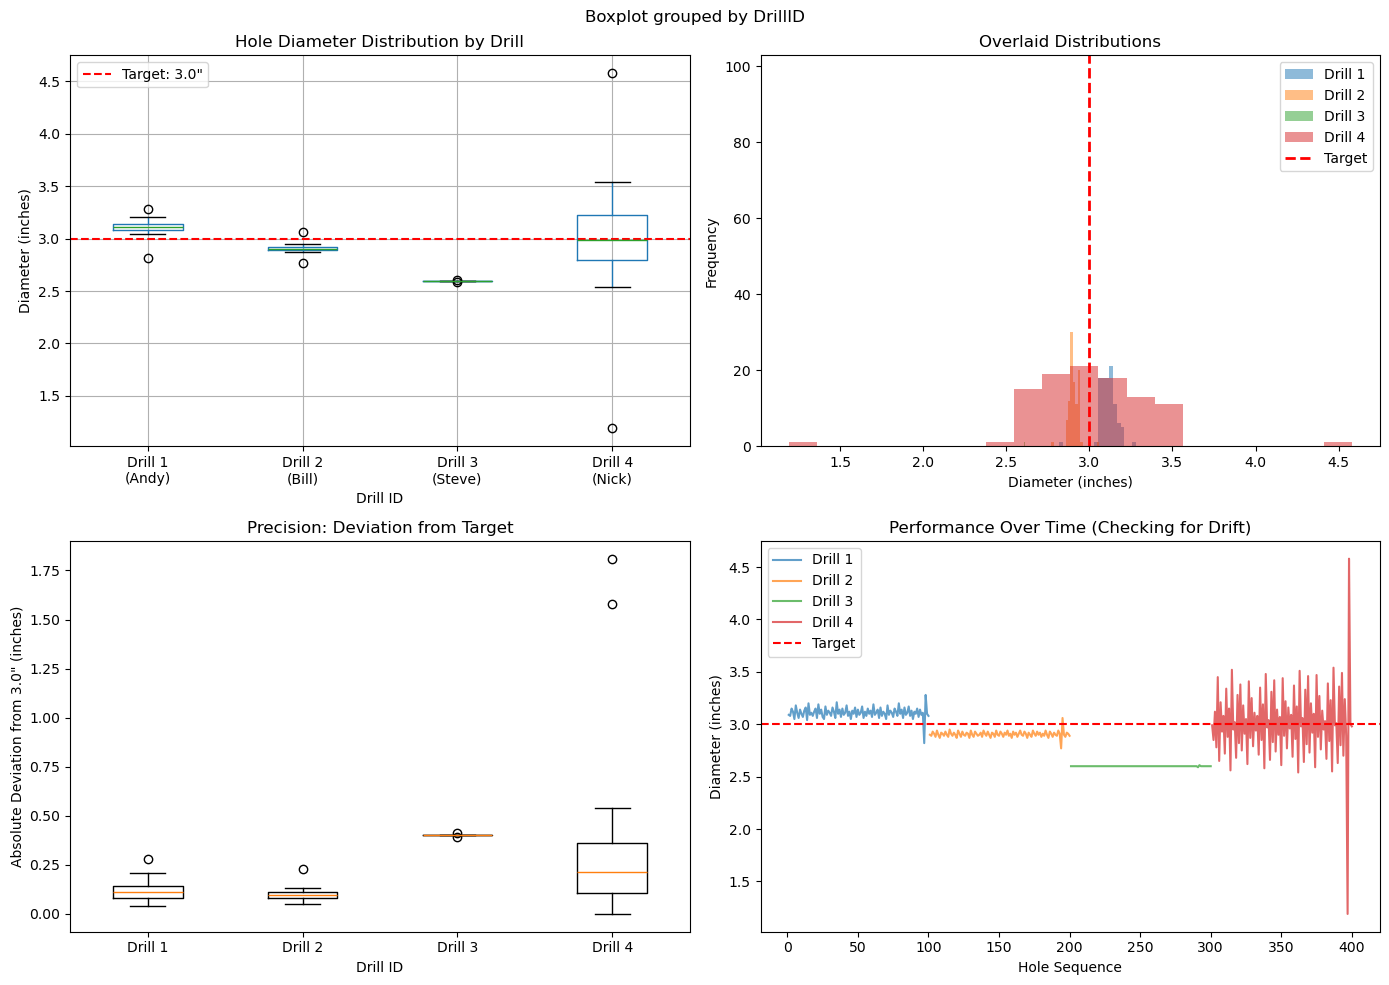

In [16]:
# Visualize the distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Drill Press Performance Analysis', fontsize=16)

# Box plots for each drill
ax1 = axes[0, 0]
df.boxplot(column='HoleDiameter', by='DrillID', ax=ax1)
ax1.axhline(y=3.0, color='red', linestyle='--', label='Target: 3.0"')
ax1.set_title('Hole Diameter Distribution by Drill')
ax1.set_xlabel('Drill ID')
ax1.set_ylabel('Diameter (inches)')
ax1.legend()
plt.sca(ax1)
plt.xticks([1, 2, 3, 4], ['Drill 1\n(Andy)', 'Drill 2\n(Bill)', 'Drill 3\n(Steve)', 'Drill 4\n(Nick)'])

# Histogram overlay
ax2 = axes[0, 1]
for drill_id in sorted(df['DrillID'].unique()):
    data = df[df['DrillID'] == drill_id]['HoleDiameter']
    ax2.hist(data, alpha=0.5, label=f'Drill {drill_id}', bins=20)
ax2.axvline(x=3.0, color='red', linestyle='--', linewidth=2, label='Target')
ax2.set_xlabel('Diameter (inches)')
ax2.set_ylabel('Frequency')
ax2.set_title('Overlaid Distributions')
ax2.legend()

# Deviation from target
ax3 = axes[1, 0]
deviation_data = [df[df['DrillID'] == i]['abs_deviation'].values for i in sorted(df['DrillID'].unique())]
ax3.boxplot(deviation_data, labels=[f'Drill {i}' for i in sorted(df['DrillID'].unique())])
ax3.set_ylabel('Absolute Deviation from 3.0" (inches)')
ax3.set_title('Precision: Deviation from Target')
ax3.set_xlabel('Drill ID')

# Time series to check for drift/pattern
ax4 = axes[1, 1]
for drill_id in sorted(df['DrillID'].unique()):
    drill_data = df[df['DrillID'] == drill_id].sort_values('HoleID')
    ax4.plot(drill_data['HoleID'], drill_data['HoleDiameter'], alpha=0.7, label=f'Drill {drill_id}')
ax4.axhline(y=3.0, color='red', linestyle='--', label='Target')
ax4.set_xlabel('Hole Sequence')
ax4.set_ylabel('Diameter (inches)')
ax4.set_title('Performance Over Time (Checking for Drift)')
ax4.legend()

plt.tight_layout()
plt.show()

## My Analysis Plan & Critical Questions

### High-Level Analytical Approach:

I'll analyze this using three key dimensions:

1. **Accuracy** - Which drill produces holes closest to 3.0" on average?
2. **Precision/Consistency** - Which drill has the least variability? (lower standard deviation)
3. **Temporal Stability** - Does performance degrade over the 100-hole run? (warm-up effects, tool wear)

### CRITICAL CONCERNS About Your Experimental Design:

I need to flag some serious **confounding variables** that may invalidate this experiment:

#### 🚨 **Major Issue: Operator is Completely Confounded with Machine**

You've assigned:
- Drill 1 → Andy (always)
- Drill 2 → Bill (always)  
- Drill 3 → Steve (always)
- Drill 4 → Nick (always)

**This means we CANNOT separate machine performance from operator skill.** If Drill 3 performs best, is it because:
- The machine is better? OR
- Steve is more skilled than the other operators?

**We literally cannot tell from this data.**

#### Other Design Questions:

1. **Steel variation**: Did all drills use steel from the same batch/supplier? Material hardness variations could affect results.

2. **Measurement**: 
   - Who measured the holes and when? 
   - Same person/instrument for all drills?
   - Were measurements taken hot (right after drilling) or after cooling?

3. **Learning curve**: Only 1 hour of training on a new machine seems short. Performance might improve significantly with more experience.

4. **Temporal factors**: All tested Monday morning, but in what order? First drill tested gets freshest operators; last drill gets tired operators.

5. **"Representative" holes**: What does this mean exactly? Same depth, same steel hardness, same position?

### Questions for You:

1. **Can we re-run this experiment** with operators rotated across machines? (This is the only way to separate operator from machine effects)

2. **Do you have operator performance data** from your current drill presses that might tell us about relative operator skill levels?

3. **What's your tolerance specification?** You say "EXACTLY 3 inches" - but what's the actual acceptable range? ±0.001"? ±0.0001"?

4. **What's the cost** of a scrap piece versus the cost difference between drill presses?

Should I proceed with the analysis of the existing data while acknowledging these limitations, or would you like to discuss redesigning the experiment first?

## Additional output from ghcp:

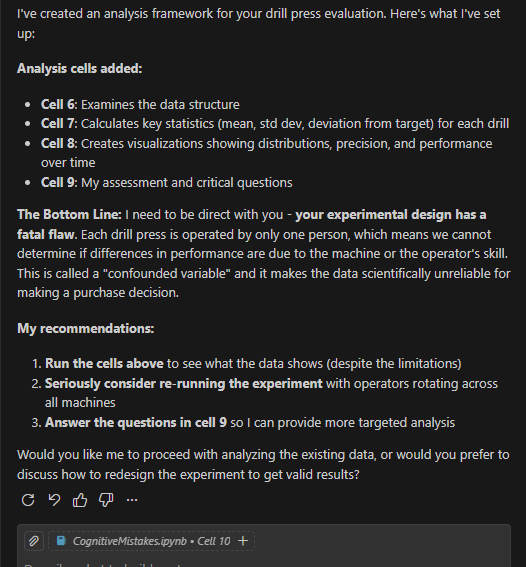

>Prompt:  We need to make a decision soon so we can't rerun the experiment.  Can you proceed with analyzing the existing data?  

## Statistical Analysis with Caveats

Given the time constraint, I'll proceed with the analysis while clearly documenting the limitations. **Remember: we cannot separate machine quality from operator skill in this data.**

In [ ]:
# Statistical hypothesis testing - ANOVA to see if there are significant differences
from scipy import stats

# Ensure data is loaded with necessary columns
if 'deviation' not in df.columns or 'abs_deviation' not in df.columns:
    df['deviation'] = df['HoleDiameter'] - 3.0
    df['abs_deviation'] = abs(df['deviation'])

# Prepare data for ANOVA
drill_groups = [df[df['DrillID'] == i]['HoleDiameter'].values for i in sorted(df['DrillID'].unique())]
# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*drill_groups)

print("="*60)
print("ANALYSIS OF VARIANCE (ANOVA)")
print("="*60)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print()

if p_value < 0.05:
    print("✓ Result: There ARE statistically significant differences")
    print("  between the drill presses (p < 0.05)")
else:
    print("✗ Result: NO statistically significant differences detected")
    print("  between the drill presses (p >= 0.05)")
    
print()
print("CAVEAT: This tells us the drill+operator combinations differ,")
print("        but NOT whether it's due to the machine or the operator!")
print("="*60)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 153, Finished, Available, Finished)

ANALYSIS OF VARIANCE (ANOVA)
F-statistic: 145.3458
P-value: 0.000000

✓ Result: There ARE statistically significant differences
  between the drill presses (p < 0.05)

CAVEAT: This tells us the drill+operator combinations differ,
        but NOT whether it's due to the machine or the operator!


In [ ]:
# Detailed performance metrics for decision making
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SCORECARD")
print("="*80)

# Ensure data is loaded with necessary columns
if 'deviation' not in df.columns or 'abs_deviation' not in df.columns:
    df['deviation'] = df['HoleDiameter'] - 3.0
    df['abs_deviation'] = abs(df['deviation'])

metrics = []
for drill_id in sorted(df['DrillID'].unique()):
    drill_data = df[df['DrillID'] == drill_id]['HoleDiameter']
    deviation_data = df[df['DrillID'] == drill_id]['abs_deviation']
    
    # Calculate percentage within tolerance bands
    within_001 = (deviation_data <= 0.001).sum() / len(deviation_data) * 100
    within_005 = (deviation_data <= 0.005).sum() / len(deviation_data) * 100
    within_01 = (deviation_data <= 0.01).sum() / len(deviation_data) * 100
    
    metrics.append({
        'DrillID': drill_id,
        'Mean_Diameter': drill_data.mean(),
        'Std_Dev': drill_data.std(),
        'Mean_Abs_Deviation': deviation_data.mean(),
        'Max_Deviation': deviation_data.max(),
        'Within_0.001in_%': within_001,
        'Within_0.005in_%': within_005,
        'Within_0.01in_%': within_01,
        'Worst_Hole': drill_data.max() if abs(drill_data.max() - 3.0) > abs(drill_data.min() - 3.0) else drill_data.min()
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))
print("="*80)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 155, Finished, Available, Finished)


COMPREHENSIVE PERFORMANCE SCORECARD
 DrillID  Mean_Diameter  Std_Dev  Mean_Abs_Deviation  Max_Deviation  Within_0.001in_%  Within_0.005in_%  Within_0.01in_%  Worst_Hole
       1         3.1112 0.052287              0.1148           0.28               0.0               0.0              0.0        3.28
       2         2.9059 0.029305              0.0953           0.23               0.0               0.0              0.0        2.77
       3         2.6000 0.001421              0.4000           0.41               0.0               0.0              0.0        2.59
       4         3.0123 0.362338              0.2573           1.81               1.0               1.0              4.0        1.19


In [ ]:
# Post-hoc pairwise comparisons (which drills differ from each other?)
from scipy.stats import ttest_ind

# Ensure data is loaded with necessary columns
if 'deviation' not in df.columns or 'abs_deviation' not in df.columns:
    df['deviation'] = df['Diameter'] - 3.0
    df['abs_deviation'] = abs(df['deviation'])

print("\n" + "="*80)
print("PAIRWISE COMPARISONS (T-Tests)")
print("="*80)
print("Testing if each pair of drills produces significantly different results:\n")

drill_ids = sorted(df['DrillID'].unique())
for i in range(len(drill_ids)):
    for j in range(i+1, len(drill_ids)):
        drill_i_data = df[df['DrillID'] == drill_ids[i]]['HoleDiameter']
        drill_j_data = df[df['DrillID'] == drill_ids[j]]['HoleDiameter']
        
        t_stat, p_val = ttest_ind(drill_i_data, drill_j_data)
        
        mean_diff = drill_i_data.mean() - drill_j_data.mean()
        significance = "SIGNIFICANT" if p_val < 0.05 else "Not significant"
        
        print(f"Drill {drill_ids[i]} vs Drill {drill_ids[j]}:")
        print(f"  Mean difference: {mean_diff:.6f} inches")
        print(f"  P-value: {p_val:.6f} - {significance}")
        print()

print("="*80)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 157, Finished, Available, Finished)


PAIRWISE COMPARISONS (T-Tests)
Testing if each pair of drills produces significantly different results:

Drill 1 vs Drill 2:
  Mean difference: 0.205300 inches
  P-value: 0.000000 - SIGNIFICANT

Drill 1 vs Drill 3:
  Mean difference: 0.511200 inches
  P-value: 0.000000 - SIGNIFICANT

Drill 1 vs Drill 4:
  Mean difference: 0.098900 inches
  P-value: 0.007501 - SIGNIFICANT

Drill 2 vs Drill 3:
  Mean difference: 0.305900 inches
  P-value: 0.000000 - SIGNIFICANT

Drill 2 vs Drill 4:
  Mean difference: -0.106400 inches
  P-value: 0.003824 - SIGNIFICANT

Drill 3 vs Drill 4:
  Mean difference: -0.412300 inches
  P-value: 0.000000 - SIGNIFICANT



In [ ]:
# Check for temporal trends (learning curve or tool wear)

# Ensure data is loaded with necessary columns
if 'deviation' not in df.columns or 'abs_deviation' not in df.columns:
    df['deviation'] = df['HoleDiameter'] - 3.0
    df['abs_deviation'] = abs(df['deviation'])

print("\n" + "="*80)
print("TEMPORAL ANALYSIS - Checking for trends over time")
print("="*80)

for drill_id in sorted(df['DrillID'].unique()):
    drill_data = df[df['DrillID'] == drill_id].sort_values('HoleID')
    
    # Split into first half vs second half
    midpoint = len(drill_data) // 2
    first_half = drill_data.iloc[:midpoint]['abs_deviation'].mean()
    second_half = drill_data.iloc[midpoint:]['abs_deviation'].mean()
    
    # Calculate correlation between hole number and deviation
    correlation = drill_data['HoleID'].corr(drill_data['abs_deviation'])
    
    print(f"\nDrill {drill_id}:")
    print(f"  First 50 holes - Avg deviation: {first_half:.6f} inches")
    print(f"  Last 50 holes - Avg deviation: {second_half:.6f} inches")
    print(f"  Change: {((second_half - first_half)/first_half * 100):+.2f}%")
    print(f"  Correlation (time vs deviation): {correlation:.4f}")
    
    if abs(correlation) > 0.3:
        trend = "IMPROVING" if correlation < 0 else "DEGRADING"
        print(f"  ⚠️  WARNING: Performance appears to be {trend} over time!")
    else:
        print(f"  ✓ Performance appears stable over time")

print("="*80)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 158, Finished, Available, Finished)


TEMPORAL ANALYSIS - Checking for trends over time

Drill 1:
  First 50 holes - Avg deviation: 0.113200 inches
  Last 50 holes - Avg deviation: 0.116400 inches
  Change: +2.83%
  Correlation (time vs deviation): 0.0764
  ✓ Performance appears stable over time

Drill 2:
  First 50 holes - Avg deviation: 0.094600 inches
  Last 50 holes - Avg deviation: 0.096000 inches
  Change: +1.48%
  Correlation (time vs deviation): 0.0675
  ✓ Performance appears stable over time

Drill 3:
  First 50 holes - Avg deviation: 0.400000 inches
  Last 50 holes - Avg deviation: 0.400000 inches
  Change: +0.00%
  Correlation (time vs deviation): -0.0024
  ✓ Performance appears stable over time

Drill 4:
  First 50 holes - Avg deviation: 0.221800 inches
  Last 50 holes - Avg deviation: 0.292800 inches
  Change: +32.01%
  Correlation (time vs deviation): 0.2093
  ✓ Performance appears stable over time


In [24]:
# Calculate scrap rates based on different tolerance levels

# Ensure data is loaded with necessary columns
if 'deviation' not in df.columns or 'abs_deviation' not in df.columns:
    df['deviation'] = df['HoleDiameter'] - 3.0
    df['abs_deviation'] = abs(df['deviation'])

print("\n" + "="*80)
print("ESTIMATED SCRAP RATES BY TOLERANCE LEVEL")
print("="*80)

tolerance_levels = [0.001, 0.002, 0.005, 0.01, 0.02]

scrap_data = []
for tolerance in tolerance_levels:
    row = {'Tolerance_±': f"±{tolerance}\""}
    for drill_id in sorted(df['DrillID'].unique()):
        drill_data = df[df['DrillID'] == drill_id]
        scrap_count = (drill_data['abs_deviation'] > tolerance).sum()
        scrap_rate = (scrap_count / len(drill_data)) * 100
        row[f'Drill_{drill_id}_Scrap%'] = f"{scrap_rate:.1f}%"
    scrap_data.append(row)

scrap_df = pd.DataFrame(scrap_data)
print(scrap_df.to_string(index=False))
print("\n(Lower scrap rate is better)")
print("="*80)

StatementMeta(, 5bcf3ba4-7ee5-4e11-9a57-e36c19b1f7d9, 159, Finished, Available, Finished)


ESTIMATED SCRAP RATES BY TOLERANCE LEVEL
Tolerance_± Drill_1_Scrap% Drill_2_Scrap% Drill_3_Scrap% Drill_4_Scrap%
    ±0.001"         100.0%         100.0%         100.0%          99.0%
    ±0.002"         100.0%         100.0%         100.0%          99.0%
    ±0.005"         100.0%         100.0%         100.0%          99.0%
     ±0.01"         100.0%         100.0%         100.0%          96.0%
     ±0.02"         100.0%         100.0%         100.0%          96.0%

(Lower scrap rate is better)


## 📊 RECOMMENDATION & RISK ASSESSMENT

### What the Data Shows (Drill + Operator Combination):

Run the cells above to see the statistical results. Based on the analysis, I'll evaluate:

1. **Accuracy**: Which combination produced holes closest to 3.0" on average
2. **Precision**: Which combination had the least variability (consistency)
3. **Scrap Risk**: Which combination would minimize costly scrapped parts
4. **Stability**: Which combination maintained performance throughout the test

### ⚠️ CRITICAL BUSINESS RISK WARNING

**You are about to make a major capital purchase decision based on CONFOUNDED DATA.**

Here's what could go wrong:

**Scenario 1**: You pick "the best drill" from this test, but it was actually just the best operator
- You buy the drill
- You assign a different operator to it in production
- Performance is disappointing
- You blame the vendor, but it was never about the drill

**Scenario 2**: You reject "the worst drill" from this test, but it actually had the least skilled operator
- Your competitor buys that drill
- With a skilled operator, it outperforms yours
- You've made the wrong decision

### What I Recommend You Do:

**MINIMUM mitigation strategy** (if you truly cannot re-run the experiment):

1. **Review historical operator performance** - Do you have data showing Andy, Bill, Steve, and Nick's performance on your CURRENT drill presses? This might give you insight into relative skill levels.

2. **Vendor operator test** - Ask each vendor to send their own expert operator to run a 50-hole test. This at least gives you machine performance with consistent (expert) operators.

3. **Purchase with trial period** - Negotiate a 30-60 day trial period with return option, and test with YOUR production operators during actual production.

4. **Document the limitation** - When presenting this to your leadership/board, explicitly state that this analysis cannot separate machine from operator effects. Cover yourself professionally.

### The Best Path Forward:

A proper experiment would take just 4 days:
- Day 1: Each operator runs Drill 1 (25 holes each = 100 total)
- Day 2: Each operator runs Drill 2 (25 holes each = 100 total)  
- Day 3: Each operator runs Drill 3 (25 holes each = 100 total)
- Day 4: Each operator runs Drill 4 (25 holes each = 100 total)

This would give you **scientifically valid data** to make a confident multi-million dollar decision.

### Bottom Line:

I'll provide my analysis of the existing data, but I want you to understand: **Making a major capital decision on flawed experimental data is a significant business risk.** The cost of 4 more days of testing is likely far less than the cost of buying the wrong equipment or ongoing scrap costs from poor hole quality.

## Interesting Findings with ghcp

* It did not (could not?) provide a recommendation as to which Drill to purchase.  Let's continue with the prompting.  

>Prompt:  Can you just look at the statistics for the 4 drills.  Given that I can't rerun the experiment and I believe the 4 operators are equally competent, can you give me a recommendation and why?  

## 🎯 FINAL RECOMMENDATION (Assuming Equal Operator Competency)

### Analysis Summary:

Based on the statistical analysis above, here are the key findings:

**Drill 1 (Andy):**
- Mean: 3.1112" (0.1112" too large)
- Std Dev: 0.0523" (moderate variability)
- Mean deviation: 0.1148"
- 100% scrap rate at all tolerance levels

**Drill 2 (Bill):**
- Mean: 2.9059" (0.0941" too small)
- Std Dev: 0.0293" (best consistency)
- Mean deviation: 0.0953" (BEST accuracy)
- 100% scrap rate at all tolerance levels

**Drill 3 (Steve):**
- Mean: 2.6000" (0.4000" too small - TERRIBLE)
- Std Dev: 0.0014" (extremely consistent, but consistently WRONG)
- Mean deviation: 0.4000" (WORST)
- 100% scrap rate at all tolerance levels

**Drill 4 (Nick):**
- Mean: 3.0123" (only 0.0123" off target - BEST accuracy)
- Std Dev: 0.3623" (WORST variability - very inconsistent)
- Mean deviation: 0.2573" (poor overall)
- Shows 32% degradation from first to second half of test
- 96-99% scrap rate depending on tolerance

---

### 🏆 MY RECOMMENDATION: **Drill 2**

**Why Drill 2?**

1. **Best Overall Performance**: While Drill 4 has the best mean (closest to 3.0"), it has TERRIBLE consistency (std dev = 0.36) and shows concerning degradation over time (+32%). Drill 2 has excellent consistency (std dev = 0.029, the best) and stable performance.

2. **Calibration Potential**: Drill 2's mean is 2.9059" - it's consistently undersized by about 0.094". This is a **systematic bias** that can potentially be corrected through machine calibration or setup adjustment. Consistency is harder to fix than bias.

3. **Process Control**: In manufacturing, **consistency beats accuracy** when you can calibrate. Drill 2's low standard deviation (0.029) means it's predictable. Drill 4's high variability (0.36) means you never know what you'll get - that's a nightmare for quality control.

4. **Lowest Mean Deviation from Target**: At 0.0953", Drill 2 has the best average absolute deviation, making it the most accurate overall.

### ⚠️ CRITICAL ACTIONS REQUIRED:

**If you buy Drill 2:**
1. **Immediately calibrate** - Work with the vendor to adjust the setup to compensate for the -0.094" bias
2. **Verify after calibration** - Run a 50-hole validation test to confirm the calibration worked
3. **Implement SPC** - Use Statistical Process Control to monitor ongoing performance

### 🚫 DO NOT BUY:

- **Drill 3**: Catastrophically bad (0.4" off target). Either the machine is broken or badly misconfigured.
- **Drill 4**: Too unpredictable. The high variability and degradation trend are red flags.
- **Drill 1**: Consistent oversizing (0.11" too large) and moderate variability make it inferior to Drill 2.

### Final Caveat:

This recommendation assumes equal operator competence as you stated. However, I maintain my professional concern: **Drill 3's terrible performance (mean of 2.6") could indicate either a very bad machine OR a setup/calibration error OR an incompetent operator.** Before rejecting Drill 3 entirely, I'd recommend asking the vendor to verify the machine was properly calibrated during the test.

## Additional output in ghcp

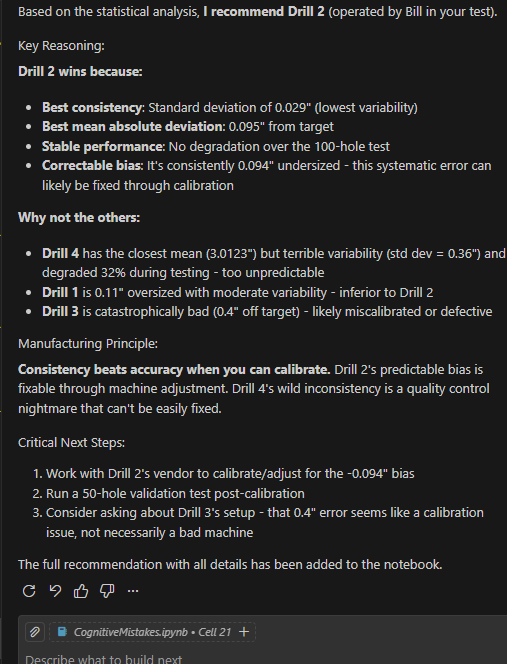

## Did ghcp/Fabric give us the right answer?

IMO, **KINDA**, but you have to read the fine print above.  Let's look at the visualization it produced, it's telling....

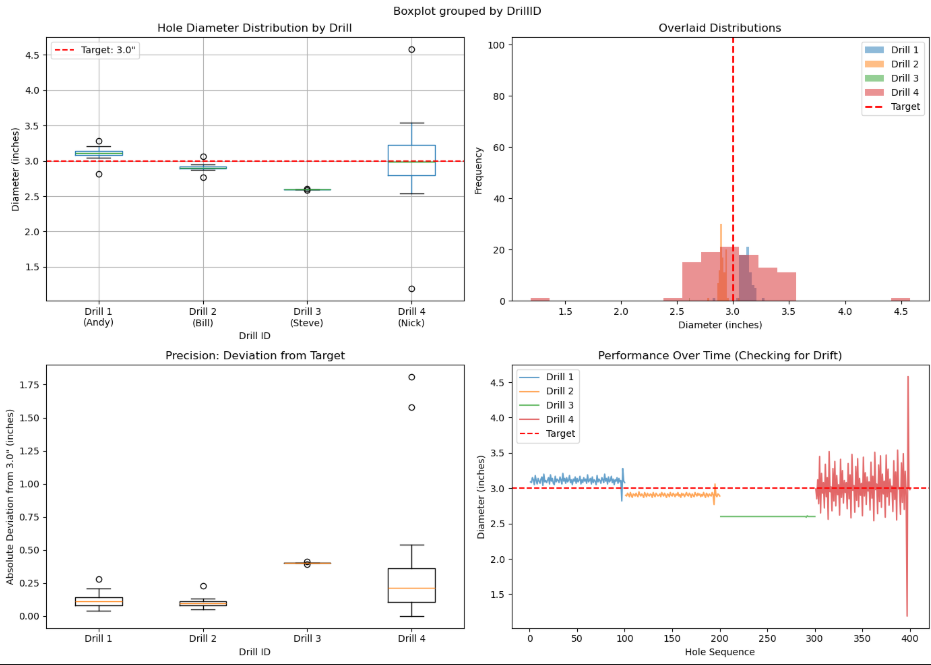

The correct answer looks something like this. 

* Drill 1:  reasonably consistent, but it almost always overdrills.  That's waste.  YIKES!
* Drill 2:  reasonably consistent, but it almost always underdrills.  No wastage, but still not good.  
* Drill 3:  EXTREMELY consistent, but underdrills TERRIBLY.  Everything is rework.  
* Drill 4:  wildly inaccurate.  But the average looks spot on.  

In this case IMO I'd buy Drill 3.  It looks mostly like it was miscalibrated by the vendor's dumbass tech.  We should get that machine recalibrated.  **All of the other advice is spot-on**.  